In [6]:
from math import sqrt, ceil
import numpy as np
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt
import cirq
import openfermion as of
from openfermionpyscf import run_pyscf

In [7]:
def eps2_bound(hamiltonian: cirq.PauliSum) -> float:
    """Get a bound on eps2."""

    M = len(hamiltonian)
    coeffs = np.array([ps.coefficient for ps in hamiltonian])
    i_max = np.argmax(np.abs(coeffs))
    max_coeff = coeffs[i_max]
    n_summands = M
    return (-1. / 24) * 0.5 * max_coeff ** 3 * n_summands ** 3

## Bounds for Hubbard

In [8]:
energy_error = 1e-3

In [9]:
# Hubbard

t = 1.0
u = 4.0
ls = [2, 3, 4]
eps2_bounds = []
dt_bounds = []
taus = []
nsteps = []
for l in ls:
    ham = of.fermi_hubbard(l, l, t, u, spinless=True)
    ham_jw = of.transforms.jordan_wigner(ham)
    ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
    bound = eps2_bound(ham_cirq)
    eps2_bounds.append(bound)
    dt = sqrt(energy_error / abs(bound))
    dt_bounds.append(dt)
    ham_sparse = of.linalg.get_sparse_operator(ham_jw)
    ham_norm = norm(ham_sparse, ord=2)
    tau = np.pi / (4. * ham_norm)
    taus.append(tau)
    ns = ceil(tau / dt)
    nsteps.append(ns)

for i in range(len(ls)):
    print(ls[i], taus[i], nsteps[i])

2 0.04908738521234052 126
3 0.01090830782496456 1947
4 0.006135923151542623 6090


/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited at iteration 20 with accuracies 
[0.00160814]
not reaching the requested tolerance 0.0009765625.
Use iteration 21 instead with accuracy 
0.001608135271017929.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/Users/benjamindalfavero/.venv/compare/lib/python3.13/site-packages/scipy/sparse/linalg/_eigen/_svds.py:477: UserWarning: Exited postprocessing with accuracies 
[0.00160814]
not reaching the requested tolerance 0.0009765625.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


In [13]:
# Hyrdogen chains

ls = [2, 4, 6, 8, 10, 12, 14]
eps2_bounds = []
dt_bounds = []
taus = []
nsteps = []
for l in ls:
    print(f"l={l}")
    bond_length = 1.0 
    natoms = l
    geometry = [("H", (0, 0, i * bond_length)) for i in range(natoms)]
    molecule = of.MolecularData(geometry, basis="sto-3g", multiplicity=1, charge=0)
    molecule = run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)
    fermion_hamiltonian = of.get_fermion_operator(molecule.get_molecular_hamiltonian())
    ham_jw = of.jordan_wigner(fermion_hamiltonian)
    nterms = len(ham_jw.terms)
    ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)

    bound = eps2_bound(ham_cirq)
    eps2_bounds.append(bound)
    dt = sqrt(energy_error / abs(bound))
    dt_bounds.append(dt)
    # ham_sparse = of.linalg.get_sparse_operator(ham_jw)
    # ham_norm = norm(ham_sparse, ord=2)
    # tau = np.pi / (4. * ham_norm)

    # Approximate the norm of the Hamiltonian with the triangle inequality.
    # This is an upper bond on the norm, so we will have smaller tau than we should.
    coeffs = np.array([ps.coefficient for ps in ham_cirq])
    ham_norm = np.sum(np.abs(coeffs))
    tau = np.pi / (4. * ham_norm)

    taus.append(tau)
    ns = ceil(tau / dt)
    nsteps.append(ns)

for i in range(len(ls)):
    print(ls[i], taus[i], nsteps[i])

l=2
l=4
l=6
l=8
l=10
l=12
l=14
2 0.41279478724443996 21
4 0.10505102540059179 234
6 0.04370067008237355 1533
8 0.023224433997199274 5292
10 0.01416324136135583 13305
12 0.009455711625595036 27795
14 0.006719252979329445 51359


## Histogram Pauli string coefficients for different Hamiltonians

(array([1.372e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.5 ,  39.65,  78.8 , 117.95, 157.1 , 196.25, 235.4 , 274.55,
        313.7 , 352.85, 392.  ]),
 <BarContainer object of 10 artists>)

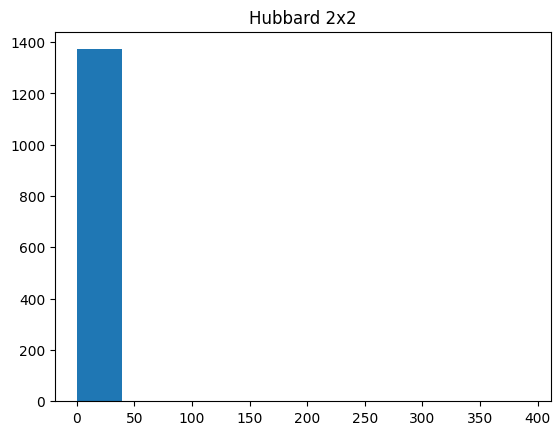

In [11]:
ham = of.fermi_hubbard(l, l, t, u, spinless=True)
ham_jw = of.transforms.jordan_wigner(ham)
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
coeffs = np.array([ps.coefficient for ps in ham_cirq])

fig, ax = plt.subplots()
ax.set_title("Hubbard 2x2")
ax.hist(np.abs(coeffs))

In [12]:
bond_length = 1.0 
natoms = l
geometry = [("H", (0, 0, i * bond_length)) for i in range(natoms)]
molecule = of.MolecularData(geometry, basis="sto-3g", multiplicity=1, charge=0)
molecule = run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)
fermion_hamiltonian = of.get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_jw = of.jordan_wigner(fermion_hamiltonian)
nterms = len(ham_jw.terms)
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
coeffs = np.array([ps.coefficient for ps in ham_cirq])

fig, ax = plt.subplots()
ax.set_title(f"Hydrogen chain l={l}")
ax.hist(np.abs(coeffs))

KeyboardInterrupt: 

# Get a looser bound using just the coefficients.

In [ ]:
def eps2_coeff_bound(hamiltonian: cirq.PauliSum) -> float:
    """Get a bound by summing coeffs."""

    M = len(hamiltonian)
    coeffs = [ps.coefficient for ps in hamiltonian]
    # print(f"M = {M}")
    h_sum = 0.
    for mu in range(2 * M - 1):
        if mu >= M:
            i = mu - M
            h_mu = coeffs[M - 1 - i]
        else:
            h_mu = coeffs[mu]
        for nu in range(mu+1, 2 * M):
            # print(f"nu = {nu}")
            if nu >= M:
                i = nu - M
                h_nu = coeffs[M - 1 - i]
            else:
                h_nu = coeffs[nu]
            for nu_prime in range(nu, 2 * M):
                # print(f"nu_prime = {nu_prime}")
                if nu_prime >= M:
                    i = nu_prime - M
                    h_nu_prime = coeffs[M - 1 - i]
                else:
                    h_nu_prime = coeffs[nu_prime]
                if nu_prime == nu:
                    delta = 1.
                else:
                    delta = 0.
                h_prod = abs(h_mu * h_nu * h_nu_prime)
                h_sum += (1. - delta / 2.) * h_prod
    return -1. / 24. * h_sum

In [ ]:
t = 1.0
u = 4.0
ls = [2, 3, 4]
eps2_bounds = []
dt_bounds = []
for l in ls:
    ham = of.fermi_hubbard(l, l, t, u, spinless=True)
    ham_jw = of.transforms.jordan_wigner(ham)
    ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
    bound = eps2_coeff_bound(ham_cirq)
    eps2_bounds.append(bound)
    dt_bounds.append(sqrt(energy_error / abs(bound)))
for l, dt in zip(ls, dt_bounds):
    print(f"{l} {dt:4.5e}")

2 1.55515e-03
3 1.60772e-04
4 6.75834e-05
